In [56]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Training:

lr = 1e-1 # Learning Rate
epochs = 300 # Number of Epochs

losses = list()

# (1) The Module superclass allows for the definition of Models
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Random starting values (sent to device)
        self.a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
        self.b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

    def forward(self, X):
        return self.a * X + self.b

model = ManualLinearRegression().to(device)

# (2) The Mean Squared Error Loss function knows how to compute the loss automatically
loss_function = nn.MSELoss(reduction='mean') # or 'sum'

# (3) The Stochastic Gradient Descent Optimizer knows how to update a and b automatically
optimizer = optim.SGD([a, b], lr=lr)


for epoch in range(epochs): # Batch Learning
    # Predicted output for all inputs
    model.train() # Set to train mode
    Y_hat = model(X_train_tensor)

    # Compute the Loss
    loss = loss_function(Y_train_tensor, Y_hat)
    losses.append(loss)

    # Compute partial derivatives (PyTorch's Autograd)
    loss.backwards()

    # Update params (using the optimizer)
    optimizer.step()
    optimizer.zero_grad() # This avoids misusage of old gradient values

print(f"Final params: a={a}, b={b}")## Manual implementation of a Single-Variate Linear Regression

In [63]:
# y = a + bx + epsilon
# a = 1, b = 2

# Data Generation
X = np.random.rand(100, 1)
Y = 1 + 2 * X + .1 * np.random.randn(100, 1)

# Split the dataset
idxs = np.arange(100)
np.random.shuffle(idxs)
train_idx = idxs[:80] # 80-20 split
val_idx = idxs[80:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]

In [28]:
# Training:

# Random starting values
a = np.random.randn(1)
b = np.random.randn(1)

lr = 1e-1 # Learning Rate
epochs = 300 # Number of Epochs

losses = list()

for epoch in range(epochs): # Batch Learning
    # Predicted output for all inputs
    Y_hat = a + b * X_train

    error = (Y_train - Y_hat)
    loss = (error ** 2).mean()
    losses.append(loss)

    # Compute partial derivatives (by hand)
    grad_a = -2 * error.mean()
    grad_b = -2 * (X_train * error).mean()

    # Update params by descending the gradients
    a = a - lr * grad_a
    b = b - lr * grad_b

print(f"Final params: a={a}, b={b}")

Final params: a=[1.02448592], b=[1.96711505]


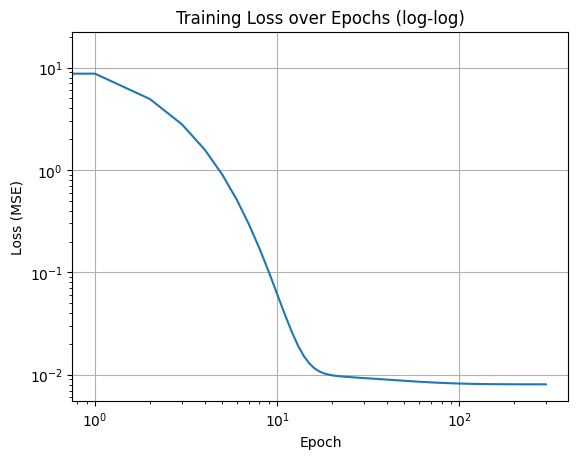

In [29]:
plt.loglog(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss over Epochs (log-log)")
plt.grid(True)
plt.show()

## PyTorch implementation of Linear Regression

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Convert into PyTorch Tensors (as of now, the tensors are in the RAM)
X_tensor = torch.from_numpy(X).float()
Y_tensor = torch.from_numpy(Y).float()

In [68]:
# Build the Dataset

dataset = TensorDataset(X_tensor, Y_tensor)

train_dataset, val_dataset = random_split(dataset, [80, 20])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16, # We do Mini-Batch this time
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=20, # (Full) Batch for the small validation set
)

In [87]:
# Training:

lr = 1e-1 # Learning Rate
epochs = 5 # Number of Epochs

train_losses = list()
val_losses = list()

# (1) The Module superclass allows for the definition of Models
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Random starting values (sent to device)
        self.a = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, X):
        return self.a + self.b * X

class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Use a Linear Layer with 1 input and 1 output
        self.linear = nn.Linear(in_features=1, out_features=1, bias=True)

    def forward(self, X):
        return self.linear(X)

model = LayerLinearRegression().to(device)

# (2) The Mean Squared Error Loss function knows how to compute the loss automatically
loss_function = nn.MSELoss(reduction='mean') # or 'sum'

# (3) The Stochastic Gradient Descent Optimizer knows how to update a and b automatically
optimizer = optim.SGD(model.parameters(), lr=lr)


for epoch in range(epochs): # Mini-Batch Learning (thanks to TensorDataset)
    for X_batch, Y_batch in train_loader:
        # Only the mini-batch is transferred to the GPU
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        model.train() # Set to train mode
        Y_hat = model(X_batch)

        # Compute the Loss
        loss = loss_function(Y_batch, Y_hat)
        train_losses.append(loss.item())

        # Compute partial derivatives (PyTorch's Autograd)
        loss.backward()

        # Update params (using the optimizer)
        optimizer.step()
        optimizer.zero_grad() # This avoids misusage of old gradient values

        # We can do Evaluation in the inner Loop
        for X_val, Y_val in val_loader:
            x_val = X_val.to(device)
            y_val = Y_val.to(device)
            model.eval()
            Y_hat = model(x_val)
            loss = loss_function(y_val, Y_hat)
            val_losses.append(loss.item())

print(f"Final params: a={a}, b={b}")

Final params: a=[1.02448592], b=[1.96711505]


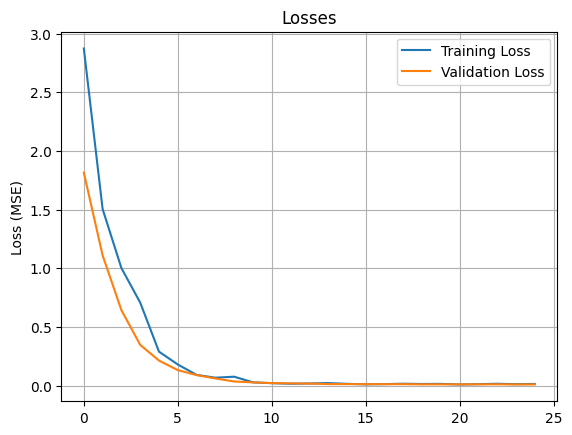

In [89]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("")
plt.ylabel("Loss (MSE)")
plt.title("Losses")
plt.grid(True)
plt.legend()
plt.show()